In this notebook we are going to check and prepare the data.

In [2]:
import pandas as pd
from IPython.display import Image
import json
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier
%matplotlib inline

In [36]:
pd.set_option("display.max_colwidth", 200)

In [3]:
import os
data_path = os.path.abspath('..')+'/data/'
data_path

'/Users/benjibred/Projects/Python/PokeApi-with-Superlinked/data/'

Let us get basic understanding about the data.

In [4]:
pokedex_df = pd.read_csv(data_path+"pokedex.csv").drop(columns=["Unnamed: 0"])
pokedex_df.head()

,id,name,abilities,color,shape,habitat,capture_chance,height,weight,poke_type,sprite
0,1,bulbasaur,"['overgrow', 'chlorophyll']",green,quadruped,grassland,0.18,7,69,grass,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/1.png
1,2,ivysaur,"['overgrow', 'chlorophyll']",green,quadruped,grassland,0.18,10,130,grass,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/2.png
2,3,venusaur,"['overgrow', 'chlorophyll']",green,quadruped,grassland,0.18,20,1000,grass,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/3.png
3,4,charmander,"['blaze', 'solar-power']",red,upright,mountain,0.18,6,85,fire,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/4.png
4,5,charmeleon,"['blaze', 'solar-power']",red,upright,mountain,0.18,11,190,fire,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/5.png


In [5]:
pokedex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1023 non-null   int64  
 1   name            1023 non-null   object 
 2   abilities       1023 non-null   object 
 3   color           1023 non-null   object 
 4   shape           904 non-null    object 
 5   habitat         386 non-null    object 
 6   capture_chance  1023 non-null   float64
 7   height          1023 non-null   int64  
 8   weight          1023 non-null   int64  
 9   poke_type       1023 non-null   object 
 10  sprite          1023 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 88.0+ KB


In [6]:
pokedex_df['shape'].value_counts()

upright      189
quadruped    169
humanoid     137
wings         80
arms          48
ball          42
fish          41
armor         40
blob          38
squiggle      37
legs          23
tentacles     23
bug-wings     21
heads         16
Name: shape, dtype: int64

In [7]:
pokedex_df['habitat'].value_counts()

grassland        80
forest           71
waters-edge      47
mountain         45
sea              40
urban            37
cave             29
rough-terrain    27
rare             10
Name: habitat, dtype: int64

We see that shape and habitat columns contain lots of nulls. So the mission is to fill nulls in a elegant way. It should be noted that classes are imbalanced.
So the data preparation begins with cleaning and transforming the data. Abilities column are a strings so we transform it into list.

In [8]:
pokedex_df['abilities'] = pokedex_df['abilities'].str.replace("'",'''"''').apply(json.loads)

Next, we will transform abilities column into separate columns for each ability. We want to differentiate those pokemons who have one, two or three abilities. 

In [9]:
df_pred_habitat = pokedex_df['abilities'].apply(pd.Series)
df_pred_habitat = df_pred_habitat.rename(columns = lambda x : 'ability' + '_' + str(x))

In [10]:
df_pred_habitat

,ability_0,ability_1,ability_2
0,overgrow,chlorophyll,NaN
1,overgrow,chlorophyll,NaN
2,overgrow,chlorophyll,NaN
3,blaze,solar-power,NaN
4,blaze,solar-power,NaN
...,...,...,...
1018,protosynthesis,NaN,NaN
1019,protosynthesis,NaN,NaN
1020,quark-drive,NaN,NaN
1021,quark-drive,NaN,NaN


Here we prepare df to predict habitat. We will use color, capture_chance, height, weight and all three abilities columns as features.

In [11]:
df_pred_habitat = pd.concat([df_pred_habitat, pokedex_df['color'], pokedex_df['capture_chance'],
                pokedex_df['height'], pokedex_df['weight'], pokedex_df['habitat'], pokedex_df['poke_type']],axis=1)

In [12]:
df_pred_habitat['ability_1'].fillna('None', inplace=True)
df_pred_habitat['ability_2'].fillna('None', inplace=True)

In [13]:
df_pred_habitat

,ability_0,ability_1,ability_2,color,capture_chance,height,weight,habitat,poke_type
0,overgrow,chlorophyll,None,green,0.18,7,69,grassland,grass
1,overgrow,chlorophyll,None,green,0.18,10,130,grassland,grass
2,overgrow,chlorophyll,None,green,0.18,20,1000,grassland,grass
3,blaze,solar-power,None,red,0.18,6,85,mountain,fire
4,blaze,solar-power,None,red,0.18,11,190,mountain,fire
...,...,...,...,...,...,...,...,...,...
1018,protosynthesis,None,None,brown,0.04,35,5900,NaN,fire
1019,protosynthesis,None,None,yellow,0.04,52,4800,NaN,electric
1020,quark-drive,None,None,gray,0.04,15,1625,NaN,rock
1021,quark-drive,None,None,blue,0.04,16,1560,NaN,steel


Before us multi-classification problem with lots of unique non-ordinal categorical features. The best choice is to use CatBoostClassifier from CatBoost library. The classes are imbalanced, so we will use 'Balanced' option in CatBoostClassifier.

In [14]:
X = df_pred_habitat[df_pred_habitat['habitat'].notna()].drop(columns='habitat')
y = df_pred_habitat[df_pred_habitat['habitat'].notna()]['habitat']
pred_data = df_pred_habitat[df_pred_habitat['habitat'].isna()].drop(columns='habitat')

cat_vars = [var for var in X.columns if X[var].dtype == "O"]
model = CatBoostClassifier(iterations=500, depth=10, learning_rate=0.1, loss_function='MultiClass', cat_features=cat_vars, auto_class_weights='Balanced')

model.fit(X, y)
predictions_pd = pd.DataFrame({'habitat':[x[0] for x in model.predict(pred_data)]})

0:	learn: 2.1301812	total: 129ms	remaining: 1m 4s
1:	learn: 2.0761671	total: 204ms	remaining: 50.8s
2:	learn: 2.0224072	total: 289ms	remaining: 47.8s
3:	learn: 1.9743308	total: 392ms	remaining: 48.6s
4:	learn: 1.9180128	total: 402ms	remaining: 39.8s
5:	learn: 1.8725633	total: 462ms	remaining: 38s
6:	learn: 1.8300882	total: 527ms	remaining: 37.1s
7:	learn: 1.7947998	total: 601ms	remaining: 37s
8:	learn: 1.7544305	total: 685ms	remaining: 37.4s
9:	learn: 1.7173994	total: 774ms	remaining: 37.9s
10:	learn: 1.6835264	total: 858ms	remaining: 38.2s
11:	learn: 1.6442820	total: 878ms	remaining: 35.7s
12:	learn: 1.6097941	total: 964ms	remaining: 36.1s
13:	learn: 1.5772682	total: 983ms	remaining: 34.1s
14:	learn: 1.5439283	total: 1.07s	remaining: 34.5s
15:	learn: 1.5023591	total: 1.13s	remaining: 34.3s
16:	learn: 1.4848895	total: 1.14s	remaining: 32.3s
17:	learn: 1.4550343	total: 1.21s	remaining: 32.4s
18:	learn: 1.4255149	total: 1.38s	remaining: 35s
19:	learn: 1.4037631	total: 1.46s	remaining: 35

In [15]:
pred_data.reset_index(drop=True, inplace=True)
temp_pd = pd.concat([pred_data, predictions_pd], axis=1)

df_predicted_habitat = pd.concat([df_pred_habitat[df_pred_habitat['habitat'].notna()], temp_pd], axis=0)
df_predicted_habitat.reset_index(drop=True, inplace=True)

And we do the same to predict shape.

In [16]:
df_pred_shape = pd.concat([df_predicted_habitat, pokedex_df['shape']], axis=1)

X = df_pred_shape[df_pred_shape['shape'].notna()].drop(columns='shape')
y = df_pred_shape[df_pred_shape['shape'].notna()]['shape']
pred_data = df_pred_shape[df_pred_shape['shape'].isna()].drop(columns='shape')

cat_vars = [var for var in X.columns if X[var].dtype == "O"]
model = CatBoostClassifier(iterations=500, depth=10, learning_rate=0.1, loss_function='MultiClass', cat_features=cat_vars, auto_class_weights='Balanced')

model.fit(X, y)
predictions_pd = pd.DataFrame({'shape':[x[0] for x in model.predict(pred_data)]})

0:	learn: 2.5824438	total: 292ms	remaining: 2m 25s
1:	learn: 2.5289977	total: 541ms	remaining: 2m 14s
2:	learn: 2.4775637	total: 926ms	remaining: 2m 33s
3:	learn: 2.4428199	total: 1.23s	remaining: 2m 32s
4:	learn: 2.3984854	total: 1.47s	remaining: 2m 25s
5:	learn: 2.3462474	total: 1.77s	remaining: 2m 25s
6:	learn: 2.2933521	total: 2.03s	remaining: 2m 22s
7:	learn: 2.2497436	total: 2.33s	remaining: 2m 23s
8:	learn: 2.2121909	total: 2.63s	remaining: 2m 23s
9:	learn: 2.1690484	total: 3.06s	remaining: 2m 30s
10:	learn: 2.1276686	total: 3.3s	remaining: 2m 26s
11:	learn: 2.0878793	total: 3.65s	remaining: 2m 28s
12:	learn: 2.0497564	total: 4s	remaining: 2m 30s
13:	learn: 2.0106062	total: 4.29s	remaining: 2m 29s
14:	learn: 1.9780370	total: 4.34s	remaining: 2m 20s
15:	learn: 1.9448924	total: 4.68s	remaining: 2m 21s
16:	learn: 1.9133283	total: 4.99s	remaining: 2m 21s
17:	learn: 1.8786315	total: 5.3s	remaining: 2m 21s
18:	learn: 1.8782121	total: 5.3s	remaining: 2m 14s
19:	learn: 1.8439278	total: 

In [17]:
pred_data.reset_index(drop=True, inplace=True)
temp_pd = pd.concat([pred_data, predictions_pd], axis=1)

df_predicted_shape = pd.concat([df_pred_shape[df_pred_shape['shape'].notna()], temp_pd], axis=0)
df_predicted_shape.reset_index(drop=True, inplace=True)

In [18]:
df_pred_shape

,ability_0,ability_1,ability_2,color,capture_chance,height,weight,habitat,poke_type,shape
0,overgrow,chlorophyll,None,green,0.18,7,69,grassland,grass,quadruped
1,overgrow,chlorophyll,None,green,0.18,10,130,grassland,grass,quadruped
2,overgrow,chlorophyll,None,green,0.18,20,1000,grassland,grass,quadruped
3,blaze,solar-power,None,red,0.18,6,85,mountain,fire,upright
4,blaze,solar-power,None,red,0.18,11,190,mountain,fire,upright
...,...,...,...,...,...,...,...,...,...,...
1018,protosynthesis,None,None,brown,0.04,35,5900,mountain,fire,NaN
1019,protosynthesis,None,None,yellow,0.04,52,4800,grassland,electric,NaN
1020,quark-drive,None,None,gray,0.04,15,1625,mountain,rock,NaN
1021,quark-drive,None,None,blue,0.04,16,1560,rough-terrain,steel,NaN


As a final step add a description column for sentence queries. And final step is to save the updated dataframe. This will be our operating dataset.

In [38]:
sprite = pokedex_df['sprite']
name = pokedex_df['name']
id = pokedex_df['id']
pokedex_df = pd.concat([df_predicted_shape, sprite, name, id], axis=1)
pokedex_df = pokedex_df[['id', 'name', 'color', 'habitat', 'shape', 'poke_type', 'capture_chance', 'height','weight', 'ability_0','ability_1', 'ability_2', 'sprite']]

pokedex_df['description'] = pokedex_df['color'] + " " + pokedex_df['shape'] + " " + pokedex_df['name'] + " who is of " + pokedex_df['poke_type'] + " type and lives in " + pokedex_df['habitat'] + "."

pokedex_df.to_csv(data_path+"pokedex_updated.csv")

Let us peek and check that this dataframe does not contain any null values and is ready to be used for further analysis. 

In [39]:
pokedex_df.head(5)

,id,name,color,habitat,shape,poke_type,capture_chance,height,weight,ability_0,ability_1,ability_2,sprite,description
0,1,bulbasaur,green,grassland,quadruped,grass,0.18,7,69,overgrow,chlorophyll,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/1.png,green quadruped bulbasaur who is of grass type and lives in grassland.
1,2,ivysaur,green,grassland,quadruped,grass,0.18,10,130,overgrow,chlorophyll,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/2.png,green quadruped ivysaur who is of grass type and lives in grassland.
2,3,venusaur,green,grassland,quadruped,grass,0.18,20,1000,overgrow,chlorophyll,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/3.png,green quadruped venusaur who is of grass type and lives in grassland.
3,4,charmander,red,mountain,upright,fire,0.18,6,85,blaze,solar-power,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/4.png,red upright charmander who is of fire type and lives in mountain.
4,5,charmeleon,red,mountain,upright,fire,0.18,11,190,blaze,solar-power,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/5.png,red upright charmeleon who is of fire type and lives in mountain.


In [21]:
pokedex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1023 non-null   int64  
 1   name            1023 non-null   object 
 2   color           1023 non-null   object 
 3   habitat         1023 non-null   object 
 4   shape           1023 non-null   object 
 5   poke_type       1023 non-null   object 
 6   capture_chance  1023 non-null   float64
 7   height          1023 non-null   int64  
 8   weight          1023 non-null   int64  
 9   ability_0       1023 non-null   object 
 10  ability_1       1023 non-null   object 
 11  ability_2       1023 non-null   object 
 12  sprite          1023 non-null   object 
dtypes: float64(1), int64(3), object(9)
memory usage: 104.0+ KB


To see the distribution we draw the bars

<AxesSubplot:>

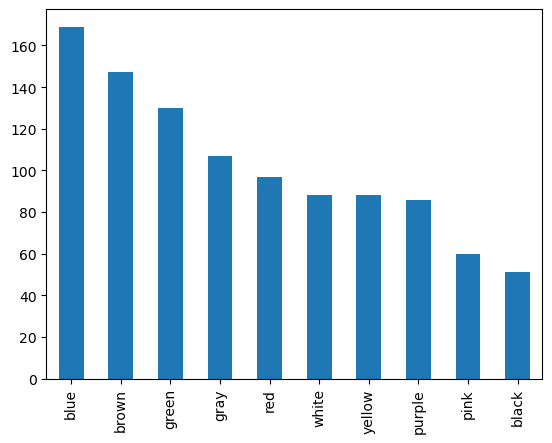

In [23]:
pokedex_df['color'].value_counts().plot.bar()

We can compare our shape prediction with pokemon.fandom. Check https://pokemon.fandom.com/wiki/List_of_Pok%C3%A9mon_by_shape.

<AxesSubplot:>

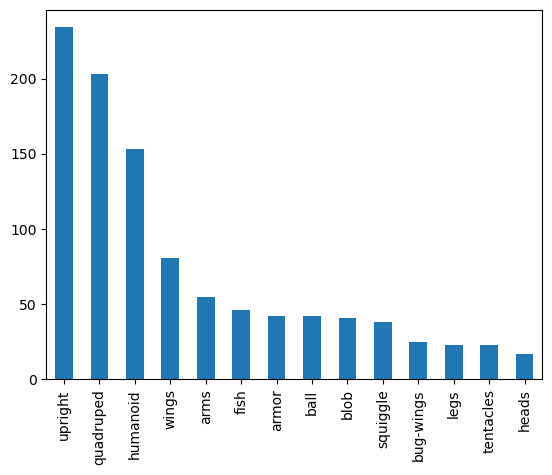

In [24]:
pokedex_df['shape'].value_counts().plot.bar()

The habitat distribution looks alike to what we see on bulbapedia (assuming they provide data according to the descending order). Check https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_habitat.

<AxesSubplot:>

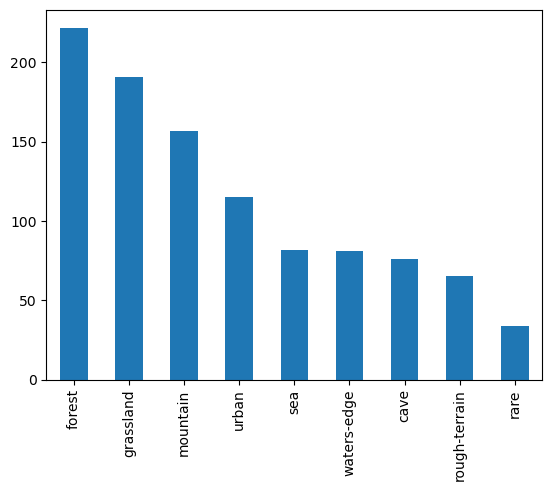

In [25]:
pokedex_df['habitat'].value_counts().plot.bar()

<AxesSubplot:>

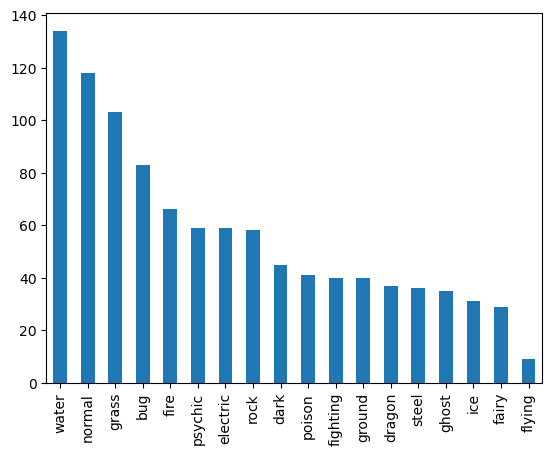

In [26]:
pokedex_df['poke_type'].value_counts().plot.bar()

The biggest pokemon:

In [27]:
max_height = pokedex_df['height'].max()
pokedex_df.query(f'height == {max_height}')

,id,name,color,habitat,shape,poke_type,capture_chance,height,weight,ability_0,ability_1,ability_2,sprite,description
888,890,eternatus,purple,grassland,wings,poison,1.0,200,9500,pressure,None,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/890.png,purple wings eternatus who is of poison type and lives in grassland.


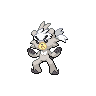

In [28]:
Image(pokedex_df.at[889, 'sprite'])

The heaviest pokemon:

In [29]:
max_weight = pokedex_df['weight'].max()
pokedex_df.query(f'weight == {max_weight}')

,id,name,color,habitat,shape,poke_type,capture_chance,height,weight,ability_0,ability_1,ability_2,sprite,description
788,790,cosmoem,blue,rare,ball,psychic,0.18,1,9999,sturdy,None,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/790.png,blue ball cosmoem who is of psychic type and lives in rare.
795,797,celesteela,green,mountain,humanoid,steel,0.18,92,9999,beast-boost,None,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/797.png,green humanoid celesteela who is of steel type and lives in mountain.


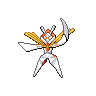

In [30]:
Image(pokedex_df.at[796, 'sprite'])

The smallest pokemon:

In [31]:
min_height = pokedex_df['height'].min()
pokedex_df.query(f'height == {min_height}')

,id,name,color,habitat,shape,poke_type,capture_chance,height,weight,ability_0,ability_1,ability_2,sprite,description
594,595,joltik,yellow,forest,armor,bug,0.75,1,6,compound-eyes,unnerve,swarm,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/595.png,yellow armor joltik who is of bug type and lives in forest.
668,669,flabebe,white,grassland,arms,fairy,0.88,1,1,flower-veil,symbiosis,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/669.png,white arms flabebe who is of fairy type and lives in grassland.
740,742,cutiefly,yellow,forest,armor,bug,0.75,1,2,honey-gather,shield-dust,sweet-veil,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/742.png,yellow armor cutiefly who is of bug type and lives in forest.
762,764,comfey,green,urban,ball,fairy,0.24,1,3,flower-veil,triage,natural-cure,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/764.png,green ball comfey who is of fairy type and lives in urban.
788,790,cosmoem,blue,rare,ball,psychic,0.18,1,9999,sturdy,None,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/790.png,blue ball cosmoem who is of psychic type and lives in rare.
852,854,sinistea,purple,cave,ball,ghost,0.47,1,2,weak-armor,cursed-body,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/854.png,purple ball sinistea who is of ghost type and lives in cave.
1010,1012,poltchageist,green,forest,arms,grass,0.47,1,11,hospitality,heatproof,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/1012.png,green arms poltchageist who is of grass type and lives in forest.


The lightest pokemon:

In [32]:
min_weight = pokedex_df['weight'].min()
pokedex_df.query(f'weight == {min_weight}')

,id,name,color,habitat,shape,poke_type,capture_chance,height,weight,ability_0,ability_1,ability_2,sprite,description
91,92,gastly,purple,cave,ball,ghost,0.75,13,1,levitate,None,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/92.png,purple ball gastly who is of ghost type and lives in cave.
92,93,haunter,purple,cave,arms,ghost,0.35,16,1,levitate,None,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/93.png,purple arms haunter who is of ghost type and lives in cave.
668,669,flabebe,white,grassland,arms,fairy,0.88,1,1,flower-veil,symbiosis,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/669.png,white arms flabebe who is of fairy type and lives in grassland.
787,789,cosmog,blue,cave,ball,psychic,0.18,2,1,unaware,None,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/789.png,blue ball cosmog who is of psychic type and lives in cave.
796,798,kartana,white,grassland,humanoid,grass,0.18,3,1,beast-boost,None,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/798.png,white humanoid kartana who is of grass type and lives in grassland.


Hardest to catch pokemon:

In [33]:
lowest_capture_chance = pokedex_df['capture_chance'].min()
pokedex_df.query(f'capture_chance == {lowest_capture_chance}')

,id,name,color,habitat,shape,poke_type,capture_chance,height,weight,ability_0,ability_1,ability_2,sprite,description
143,144,articuno,blue,rare,wings,ice,0.01,17,554,pressure,snow-cloak,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/144.png,blue wings articuno who is of ice type and lives in rare.
144,145,zapdos,yellow,rare,wings,electric,0.01,16,526,pressure,static,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/145.png,yellow wings zapdos who is of electric type and lives in rare.
145,146,moltres,yellow,rare,wings,fire,0.01,20,600,pressure,flame-body,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/146.png,yellow wings moltres who is of fire type and lives in rare.
149,150,mewtwo,purple,rare,upright,psychic,0.01,20,1220,pressure,unnerve,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/150.png,purple upright mewtwo who is of psychic type and lives in rare.
242,243,raikou,yellow,grassland,quadruped,electric,0.01,19,1780,pressure,inner-focus,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/243.png,yellow quadruped raikou who is of electric type and lives in grassland.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1007,koraidon,red,mountain,quadruped,fighting,0.01,25,3030,orichalcum-pulse,orichalcum-pulse,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/1007.png,red quadruped koraidon who is of fighting type and lives in mountain.
1006,1008,miraidon,blue,cave,quadruped,electric,0.01,35,2400,hadron-engine,hadron-engine,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/1008.png,blue quadruped miraidon who is of electric type and lives in cave.
1012,1014,okidogi,black,cave,quadruped,poison,0.01,18,922,toxic-chain,guard-dog,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/1014.png,black quadruped okidogi who is of poison type and lives in cave.
1013,1015,munkidori,black,grassland,arms,poison,0.01,10,122,toxic-chain,frisk,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/1015.png,black arms munkidori who is of poison type and lives in grassland.


Easiest to catch pokemon:

In [34]:
highest_capture_chance = pokedex_df['capture_chance'].max()
pokedex_df.query(f'capture_chance == {highest_capture_chance}')

,id,name,color,habitat,shape,poke_type,capture_chance,height,weight,ability_0,ability_1,ability_2,sprite,description
9,10,caterpie,green,forest,armor,bug,1.0,3,29,shield-dust,run-away,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/10.png,green armor caterpie who is of bug type and lives in forest.
12,13,weedle,brown,forest,armor,bug,1.0,3,32,shield-dust,run-away,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/13.png,brown armor weedle who is of bug type and lives in forest.
15,16,pidgey,brown,forest,wings,normal,1.0,3,18,keen-eye,tangled-feet,big-pecks,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/16.png,brown wings pidgey who is of normal type and lives in forest.
18,19,rattata,purple,grassland,quadruped,normal,1.0,3,35,run-away,guts,hustle,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/19.png,purple quadruped rattata who is of normal type and lives in grassland.
20,21,spearow,brown,rough-terrain,wings,normal,1.0,3,20,keen-eye,sniper,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/21.png,brown wings spearow who is of normal type and lives in rough-terrain.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,917,tarountula,white,forest,bug-wings,bug,1.0,3,40,insomnia,stakeout,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/917.png,white bug-wings tarountula who is of bug type and lives in forest.
926,928,smoliv,green,forest,upright,grass,1.0,3,65,early-bird,harvest,None,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/928.png,green upright smoliv who is of grass type and lives in forest.
930,932,nacli,brown,mountain,arms,rock,1.0,4,160,purifying-salt,sturdy,clear-body,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/932.png,brown arms nacli who is of rock type and lives in mountain.
958,960,wiglett,white,sea,fish,water,1.0,12,18,gooey,rattled,sand-veil,https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/960.png,white fish wiglett who is of water type and lives in sea.
